In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import random as rd
import sys

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [125]:
file = open("X_train.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

x = []
read_x = open("X_train.txt", "r")

for i in range(int(line_count/8)):

    x.append([float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline()), float(read_x.readline())])

read_x.close()

print("Number of points: ", len(x))

Number of points:  801


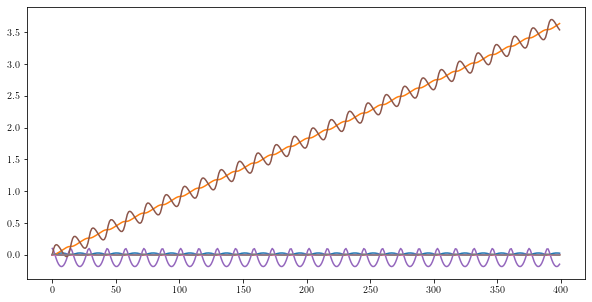

In [126]:
plt.figure(figsize=(10,5))
plt.plot(x[:400])
plt.show()

In [127]:
x_train = np.array(x[0:-1])
x_train = x_train.astype(np.float32)

y_train = np.array(x[1:])
y_train = y_train.astype(np.float32)

val_len = 1000

x_val = x_train[-val_len:]
y_val = y_train[-val_len:]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(1000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(1000)

In [128]:
class MLP(tf.keras.layers.Layer):
    
    def __init__(self):
        super(MLP, self).__init__()


    def build(self, input_shape):
        
        
        self.L1 = tf.keras.layers.Dense(50, activation='tanh')
        self.L2 = tf.keras.layers.Dense(50, activation='tanh')
        self.L3 = tf.keras.layers.Dense(8, activation='tanh')
        
    def call(self, inputs, training=False):
        
        h = self.L1(inputs)
        h = self.L2(h)
        h = self.L3(h)
        
        return h

In [129]:
class shift(tf.keras.layers.Layer):
    
    def __init__(self):

        super(shift, self).__init__()

    def build(self, input_shape):
        
        self.w = self.add_weight(
            name='w',
            shape=(8,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )
            
        self.b = self.add_weight(
            name='b',
            shape=(8,),
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None),
            trainable = True
            )


    def call(self, inputs, training=False):
        
        return self.w*inputs + self.b

In [130]:
def get_shift_and_log_scale_resnet(input_shape, blocks, shift):
    
    inputs = tf.keras.Input(shape=input_shape)
    h = inputs

    for block in blocks:
        h = block(h)

    shift, log_scale = shift(inputs), h
    log_scale = tf.math.tanh(log_scale)
    return Model(inputs=inputs, outputs=[shift, log_scale], name='name')

In [131]:
class AffineCouplingLayer(tfb.Bijector):

    def __init__(self, shift_and_log_scale_fn, mask, **kwargs):
        super(AffineCouplingLayer, self).__init__(
            forward_min_event_ndims=1, **kwargs)
        self.shift_and_log_scale_fn = shift_and_log_scale_fn
        self.b = tf.cast(mask, tf.float32)

    def _forward(self, x):
        t, log_s = self.shift_and_log_scale_fn(x * self.b)
        y = self.b * x + (1 - self.b) * (x * tf.exp(log_s) + t)
        return y

    def _inverse(self, y):
        t, log_s = self.shift_and_log_scale_fn(y * self.b)
        x = self.b * y + (1 - self.b) * ((y - t) * tf.exp(-log_s))
        return x

In [132]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., 1., 1., 1., -1., -1., -1., -1.]])

In [133]:
class RealNVPModel(tf.keras.Model):
    
    def __init__(self, shift_and_log_scale, **kwargs):
        
        super(RealNVPModel, self).__init__()
        self.R = R()
        masks = []
        self.l = []
        
        for j in range(len(shift_and_log_scale)):
            
            if j%4==0:
                masks.append(tf.constant([[0., 1., 1., 1., 0., 0., 1., .1]]))
            if j%4==1:
                masks.append(tf.constant([[1., 0., 1., 0., 0., 1., 1., 1.]]))
            if j%4==2:
                masks.append(tf.constant([[1., 0., 1., 1., 1., 1., 1., 0.]]))
            else:
                masks.append(tf.constant([[1., 1., 0., 0., 0., 1., 0., 1.]]))
        
        for i,j in zip(shift_and_log_scale, masks):
            self.l.append(AffineCouplingLayer(i, j))
        

    def call(self, input_tensor):
        
        a = self.R(input_tensor)
        
        for layer in self.l:
            a = layer._forward(a)

        a = self.R(a)

        for layer in self.l[::-1]:
            a = layer._inverse(a)
        
        return a

In [134]:
num_blocks = 8

blocks = [MLP() for i in range(num_blocks)]

#shifts = [shift() for i in range(len(blocks))]
shifts = [MLP() for i in range(len(blocks))]

shift_and_log_scale = [get_shift_and_log_scale_resnet((8), [i], j) for i,j in zip(blocks, shifts)]

In [135]:
shift_and_log_scale[0].summary()

Model: "name"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
mlp_40 (MLP)                    (None, 8)            3408        input_26[0][0]                   
__________________________________________________________________________________________________
mlp_48 (MLP)                    (None, 8)            3408        input_26[0][0]                   
__________________________________________________________________________________________________
tf.math.tanh_24 (TFOpLambda)    (None, 8)            0           mlp_40[0][0]                     
Total params: 6,816
Trainable params: 6,816
Non-trainable params: 0
___________________________

In [136]:
model = RealNVPModel(shift_and_log_scale)
model(x_train)

<tf.Tensor: shape=(800, 8), dtype=float32, numpy=
array([[ 5.2137278e-02, -4.3860596e-02,  3.7815675e-02, ...,
         1.9314952e-02,  1.4024753e-03, -1.0405277e-02],
       [ 6.9307484e-02,  5.7872504e-02,  3.2726791e-02, ...,
         6.0196809e-02,  6.5927538e-03, -5.3113446e-02],
       [ 5.8098011e-02,  1.3305859e-01,  1.1430345e-02, ...,
         7.2893478e-02,  1.3648857e-02, -6.9803663e-02],
       ...,
       [ 1.1467465e+00,  2.6236672e+00,  2.6003772e-01, ...,
         3.7110436e+00, -2.6929694e-01,  5.9236437e-01],
       [ 1.1503422e+00,  2.6413724e+00,  2.2711726e-01, ...,
         3.7310631e+00, -2.7154031e-01,  5.5974185e-01],
       [ 1.1519376e+00,  2.6531334e+00,  2.0267168e-01, ...,
         3.7312391e+00, -2.7122664e-01,  5.3849787e-01]], dtype=float32)>

In [137]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return lr
    else:
        #print(lr)
        return lr*tf.math.exp(-0.0002)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

0.002
0.002
0.002
0.002
0.002


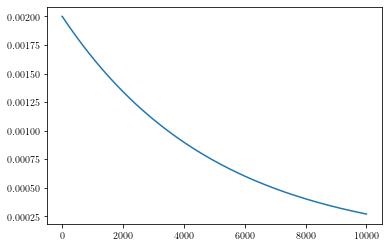

In [138]:
lr = [0.002]
for i in range(10000):
    lr.append(scheduler(i, lr[-1]))

plt.plot(lr)
plt.show()

In [139]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=tf.keras.optimizers.Adam(0.002), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(train_dataset, epochs = 10000, callbacks = [callback], verbose=1)

Epoch 1/10000
0.0020000000949949026
1/1 [==============================] - 3s 3s/step - loss: 2.0274 - accuracy: 0.5038
Epoch 2/10000
0.0020000000949949026
1/1 [==============================] - 0s 36ms/step - loss: 0.9079 - accuracy: 0.5412
Epoch 3/10000
0.0020000000949949026
1/1 [==============================] - 0s 35ms/step - loss: 0.9977 - accuracy: 0.5238
Epoch 4/10000
0.0020000000949949026
1/1 [==============================] - 0s 35ms/step - loss: 2.0340 - accuracy: 0.4437
Epoch 5/10000
0.0020000000949949026
1/1 [==============================] - 0s 34ms/step - loss: 0.7504 - accuracy: 0.5175
Epoch 6/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4758 - accuracy: 0.5412
Epoch 7/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.2552 - accuracy: 0.4950
Epoch 8/10000
1/1 [==============================] - 0s 35ms/step - loss: 0.4089 - accuracy: 0.4950
Epoch 9/10000
1/1 [==============================] - 0s 38ms/step - loss: 0.4700 - accuracy:

In [18]:
model.trainable_weights

[<tf.Variable 'shift/w:0' shape=(3,) dtype=float32, numpy=array([ 0.00160807, -0.00416988,  0.0148584 ], dtype=float32)>,
 <tf.Variable 'shift/b:0' shape=(3,) dtype=float32, numpy=array([0.08967435, 0.0024099 , 0.01236125], dtype=float32)>,
 <tf.Variable 'mlp/dense/kernel:0' shape=(3, 50) dtype=float32, numpy=
 array([[ 0.12994781,  0.13906929, -0.05903667, -0.07194436,  0.23437294,
         -0.3125073 ,  0.1325871 ,  0.24042806,  0.26857117,  0.2759789 ,
          0.00044778, -0.11839184,  0.03275627, -0.1036288 ,  0.15231746,
          0.23216292, -0.2486043 ,  0.30222335, -0.1447139 ,  0.20807174,
          0.31430098,  0.10969937,  0.22058555,  0.24301043,  0.2513537 ,
         -0.33220753, -0.05605021,  0.14434376,  0.30114016,  0.07296681,
          0.09728876, -0.31317055,  0.26473853,  0.30515614, -0.17932202,
         -0.1062831 ,  0.03429559, -0.03662875, -0.20384789, -0.32834795,
          0.04421774,  0.2563242 , -0.3022054 , -0.31707498,  0.2411944 ,
          0.15714031, 

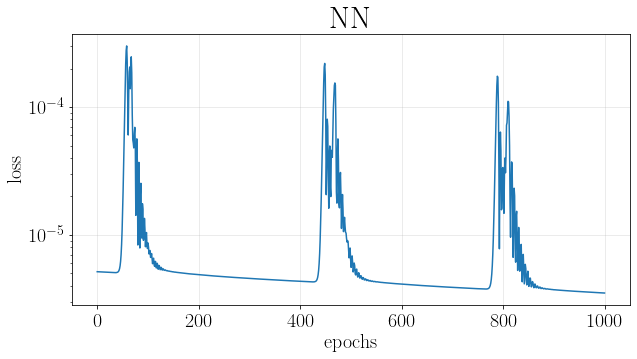

In [104]:
plt.figure(figsize = (10,5))
#plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [120]:
x0 = x_train[10]

f_iterations = [model(x0)]

In [121]:
for _ in range(10):
    f_iterations.append(model(f_iterations[-1]))

#b_iterations = [f_iterations[-1]*np.array([[-1., -1., -1.]])]

#for _ in range(100):
    #b_iterations.append(model(b_iterations[-1]))

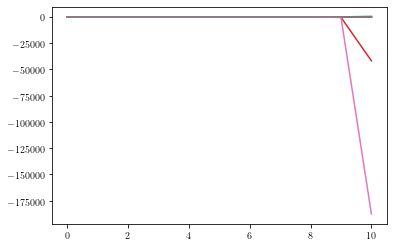

In [122]:
plt.plot([i[0].numpy() for i in f_iterations])

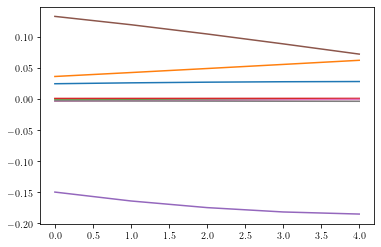

In [123]:
plt.plot(x_train[10:15])

In [124]:
y_train

array([[ 8.0828404e-04,  1.3378504e-04,  3.1356519e-04, ...,
         4.8662148e-02, -3.1356520e-03,  9.2169847e-03],
       [ 2.9731386e-03,  9.6673059e-04,  5.3282344e-04, ...,
         9.0332694e-02, -5.3282343e-03,  7.3423334e-03],
       [ 5.9478343e-03,  2.8346539e-03,  6.4043817e-04, ...,
         1.2165346e-01, -6.4043817e-03,  5.1935432e-03],
       ...,
       [ 1.5491356e-02,  1.8223394e+00, -6.0058612e-04, ...,
         1.6766056e+00,  6.0058613e-03,  4.2853114e-04],
       [ 1.2363537e-02,  1.8268144e+00, -6.4733712e-04, ...,
         1.6818560e+00,  6.4733708e-03,  1.7224055e-03],
       [ 9.0625966e-03,  1.8305620e+00, -6.6699821e-04, ...,
         1.6943799e+00,  6.6699819e-03,  3.3452539e-03]], dtype=float32)

In [84]:
model(x_train)-y_train

<tf.Tensor: shape=(400, 8), dtype=float32, numpy=
array([[-0.00055984, -0.00022432, -0.00019096, ..., -0.04120364,
         0.0033559 ,  0.00128436],
       [-0.00089648, -0.00041968, -0.00012235, ..., -0.01447354,
         0.00157259,  0.00220604],
       [-0.0009729 , -0.00105084, -0.00010581, ...,  0.00107168,
         0.0002618 ,  0.00233865],
       ...,
       [ 0.00012898, -0.00147879,  0.00055482, ...,  0.00091696,
        -0.00091054, -0.00093902],
       [ 0.00024387, -0.00187588,  0.00059383, ...,  0.000175  ,
        -0.00065751, -0.00132715],
       [ 0.00035107, -0.00211751,  0.00060735, ..., -0.00092518,
        -0.00022589, -0.00180457]], dtype=float32)>